In [24]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [25]:
parameter_values = get_parameter_values()

In [26]:
# parameter_values.search("Li")

In [27]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [28]:
cell = 4

## Load eSOH Data and OCV Data

In [29]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [30]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [31]:
Temp

25

In [32]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 5*5e-3/3600,
        # "Negative electrode LAM constant proportional term [s-1]": 5*4.3e-2/3600,
        "Positive electrode LAM constant proportional term [s-1]": 1e-7,
        "Negative electrode LAM constant proportional term [s-1]": 1e-6,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [33]:
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [34]:
# fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [35]:
# fgdfdfg

# Parameter Fitting

## List of Initial Conditions

In [36]:
ic = 1
blam_p = [1e-6,1e-7,1/5*8e-7]
blam_n = [1e-5,1e-6,1/2*5.5e-6]
k_sei= [1*2e-16,1/5*2e-16,5*2e-16]

In [37]:
dfe

N        Ah_th       x_0       y_0     x_100     y_100       C_n  \
0    0   373.756188 -0.000192  0.866865  0.821758  0.033496  5.739775   
1   41   740.552454 -0.000581  0.842564  0.816858  0.033487  5.548011   
2   82  1094.180846 -0.000927  0.815763  0.820266  0.033493  5.326477   
3  123  1433.869694 -0.001228  0.787106  0.823587  0.033500  5.064639   
4  164  1757.738800 -0.001566  0.747368  0.830057  0.033515  4.717173   
5  205  2063.188833 -0.001805  0.714797  0.833753  0.033525  4.447682   
6  246  2346.813403 -0.002087  0.674034  0.835807  0.033531  4.097134   
7  287  2605.242566 -0.002385  0.632439  0.831139  0.033518  3.788092   

        C_p       Cap  N_mod  Capacity [A.h]      n_Li  \
0  5.661127  4.722235      0        4.722235  0.183062   
1  5.605354  4.541278     40        4.541278  0.176097   
2  5.591507  4.380489     81        4.380489  0.170006   
3  5.543197  4.184328    122        4.184328  0.162561   
4  5.495401  3.932822    163        3.932822  0.152965   
5  5.454938  3.724028    204        3.724028  0.145184   
6  5.359798  3.441892    245        3.441892  0.134475   
7  5.271920  3.167571    286        3.167571  0.124065   

   Loss of lithium inventory [%]  rev_exp  irrev_exp  
0                       0.000000     98.7        0.0  
1                       3.804926     91.6       23.4  
2                       7.132077     91.5       40.1  
3                      11.199065     88.9       61.8  
4                      16.440616     80.3       91.9  
5                      20.691303     77.5      124.7  
6                      26.541129     66.5      177.7  
7                      32.227688     54.3      259.7

In [38]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    weights = [1,1,5,5]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # weights = [1,1/20]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]
    # weights = [1,1/20,1,1]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1)
def prediction_error(x):
    try:
        out=[]
        for cell in [1,4]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
            # print(f"Cell: {cell_no}")
            experiment = pybamm.Experiment(
                [
                    ("Discharge at "+c_rate_d+dis_set,
                    "Rest for 5 min",
                    "Charge at "+c_rate_c+" until 4.2V", 
                    "Hold at 4.2V until C/50")
                ] *dfe.N.iloc[-1],
                termination="50% capacity",
            #     cccv_handling="ode",
            )
            # print(f"Model")
            model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
            # print(f"Objective")
            out_t =   multi_objective(pd.DataFrame(model), dfe)
            # print(f"Concat")
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out=[]
        for cell in [1,4]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out, out_t])
        out = 2*np.ones_like(out)
        print(f"Error")
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    lower = np.array([1e-3, 1e-3, 0.5])
    upper = np.array([1e+3, 1e+3, 2])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
    return soln_dfols
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    # df['obj'][0]=soln_dfols.f
    return xsol,df

In [39]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','obj'], index=[0])

In [40]:
# sim_des = "cell_"+cell_no
# timer1 = pybamm.Timer()
train_len = len(N)
# for ic in range(0,3):
print("Initial Condition = {0}".format(ic))
x,df_x = sim_train(df_x)
# df_x.to_csv(res_DIR + "fit_train_betam_"+sim_des+'_ic'+str(ic)+".csv", index=False)

Initial Condition = 1
x=[1. 1. 1.], norm=4.508214744748721
x=[0.91692385 0.99962802 0.94433838], norm=4.446331715359304
x=[1.02820426 0.91350825 0.95848257], norm=4.488038579548345
x=[0.95201173 0.94980997 1.07195893], norm=4.5758485649803635
x=[0.90255404 1.01678152 0.84687421], norm=4.280162667262805
x=[0.71230264 1.07579584 0.5       ], norm=2.126384601942968


psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
psetup failed: .../c

Error
x=[0.54651765 2.6671837  0.5       ], norm=16.97056274847714
x=[0.60089953 1.02814255 0.5       ], norm=2.2084580675377534
x=[0.70206265 1.17527017 0.5       ], norm=1.9948770847621848
x=[0.71907177 1.273813   0.5       ], norm=1.9126151139868761
x=[1.10303707 1.38593188 0.5       ], norm=1.853776421719577
x=[1.50760681 1.39539355 0.5       ], norm=1.8393471710049285
x=[2.69575216 2.28816872 1.02933704], norm=4.2784029586642465
x=[2.61268742 2.51951395 0.56391202], norm=1.9537315163838886
x=[1.489554   1.51247864 0.60418504], norm=2.502647224902149
x=[2.25362495 1.65169527 0.5       ], norm=2.0362629953777613
x=[1.82711516 1.62663546 0.5       ], norm=1.9993900762012544
x=[1.61827842 1.55861548 0.5       ], norm=1.9231533320484837
x=[1.50668239 1.49260929 0.52341465], norm=1.781471504633547
x=[1.35544219 1.86289787 0.51984151], norm=1.9941951962034978
x=[1.44537895 1.68193579 0.54334864], norm=1.7210350634799532
x=[1.86309378 2.3580511  0.6349041 ], norm=1.9133462856547478
x=[1.3

In [41]:
sim_des="cell_1_4_test"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

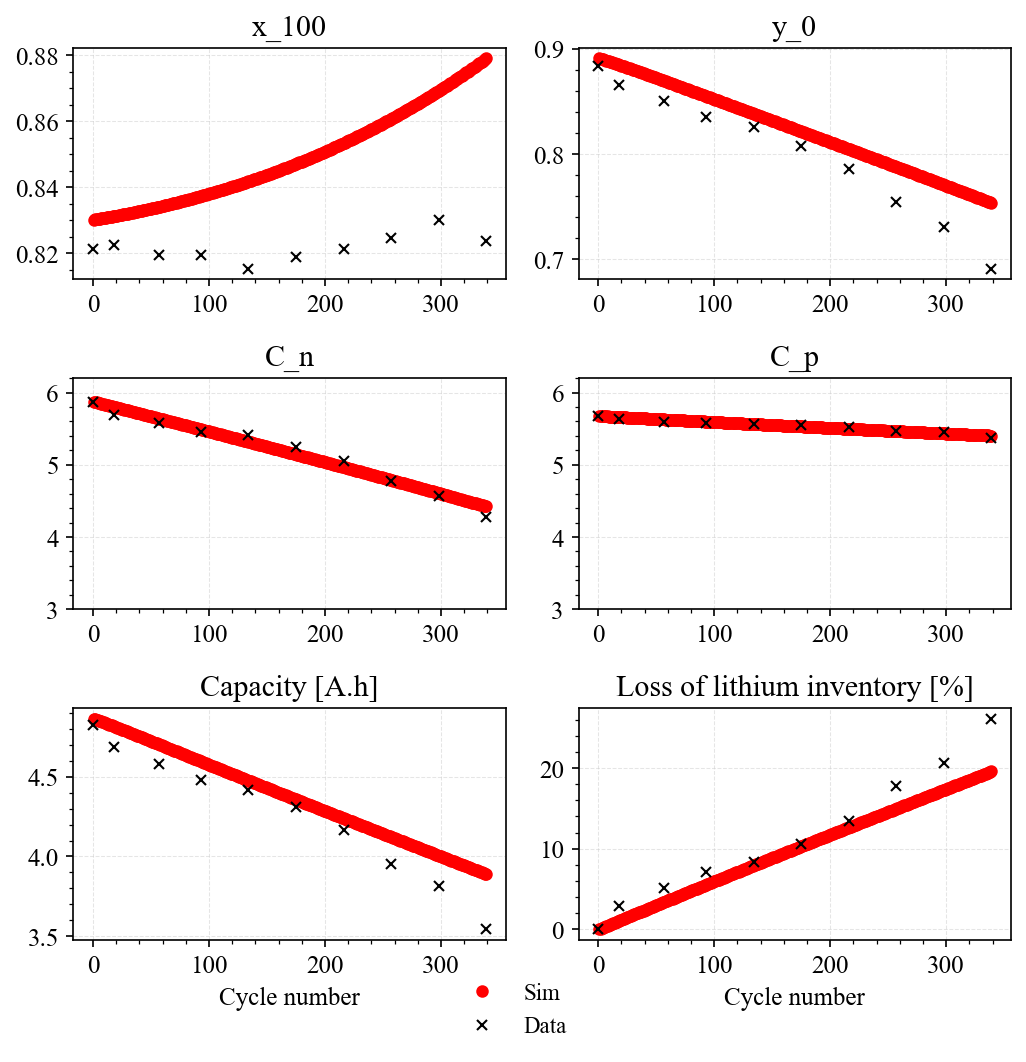

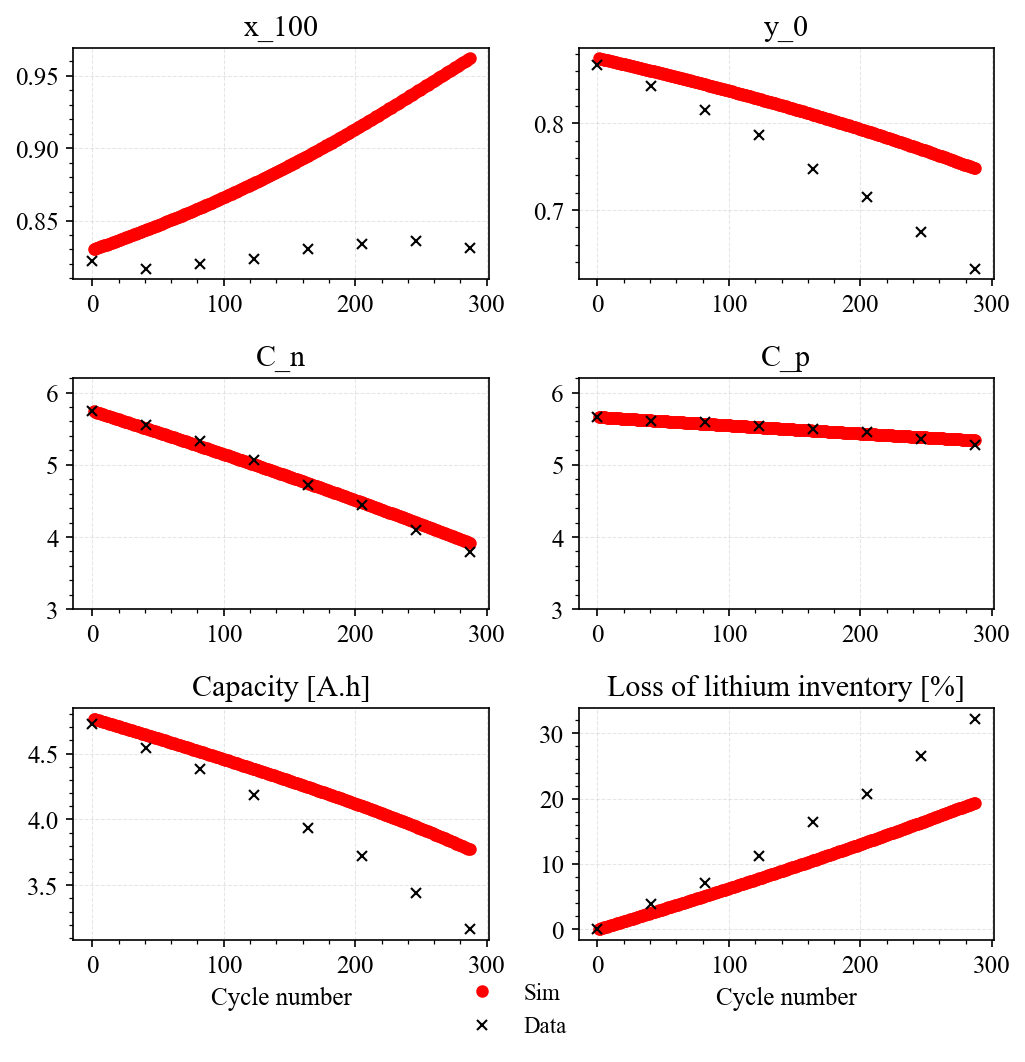

In [42]:
for cell in [1,4]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotc(sol_out,dfe);
    plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_tuning_out_test.png')

In [43]:
x

array([2.51071821, 2.47140605, 0.59691171])